## Imports

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50

# EDA

##Understanding the Problem and Data

**The Goal:**

The goal of this project is to be able to build a model that is able to accurately classify various butterfly images into one of 75 distince species. This kind of image classification model can be helpful for nature enthusiasts, who want to find as many different species of butterflies as they can. This type of model can be put in a mobile device, for users to easily be able to scan a butterfly, and determine if they have seen that species in the past.




**The Dataset:**

The dataset contains 75 different classes of Butterflies.


*   filename
  *   Image of a butterfly

*   label
  *   Butterfly type



## Importing and Inspeting the Data

Dataset: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification

In [ ]:
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

csv_path = os.path.join(path, "Training_set.csv")
df = pd.read_csv(csv_path)
df['filename'] = df['filename'].apply(lambda x: path + "/train/" + x)

df.head()

,filename,label
0,/kaggle/input/butterfly-image-classification/t...,SOUTHERN DOGFACE
1,/kaggle/input/butterfly-image-classification/t...,ADONIS
2,/kaggle/input/butterfly-image-classification/t...,BROWN SIPROETA
3,/kaggle/input/butterfly-image-classification/t...,MONARCH
4,/kaggle/input/butterfly-image-classification/t...,GREEN CELLED CATTLEHEART


In [ ]:
# relates the features to their datatypes
df.dtypes

,0
filename,object
label,object


In [ ]:
# number of rows in datafram
df_length = len(df)

In [ ]:
# number of features in the dataset
df.shape[1]

2

In [ ]:
# look at dimensions of a couple of images
for i in range(10):
  img = Image.open(df["filename"][random.randint(0, df_length-1)])
  print(img.size, img.mode)

(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB
(224, 224) RGB


## Handle Missing data

In [ ]:
# proportion of missing values (for this case, since there are no missing values, all answers will be 0) in train dataset
df.isna().sum()/df.shape[0]

,0
filename,0.0
label,0.0


## Exploring Data Characteristics

In [ ]:
# statistics of the dataset
df.describe()

,filename,label
count,6499,6499
unique,6499,75
top,/kaggle/input/butterfly-image-classification/t...,MOURNING CLOAK
freq,1,131


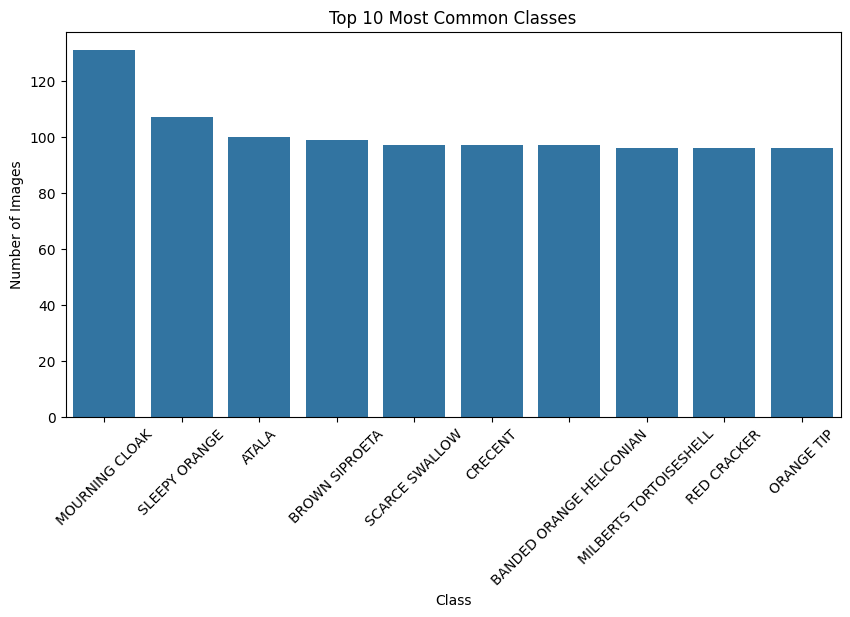

In [ ]:
top_classes = df['label'].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_classes.index, y=top_classes.values)
plt.title("Top 10 Most Common Classes")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()

## Data Transformation

In [ ]:
# generator for data transformation

# although typically we do data transformations and then split the data later in the notebook, ImageDataGenerator (in tandem with
# sklearn's train test split) easily does
# both, and so as a result I combined that step here.
datagen = ImageDataGenerator(rescale=1./255)

# train/test/validation split
train_df, test_val_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df['label'], random_state=42)

# Create training generator with shuffling and image resizing to 128x128.
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Create validation generator without shuffling for consistent evaluation.
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Create test generator without shuffling for final evaluation.
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 4549 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.


## Visualize Relationships

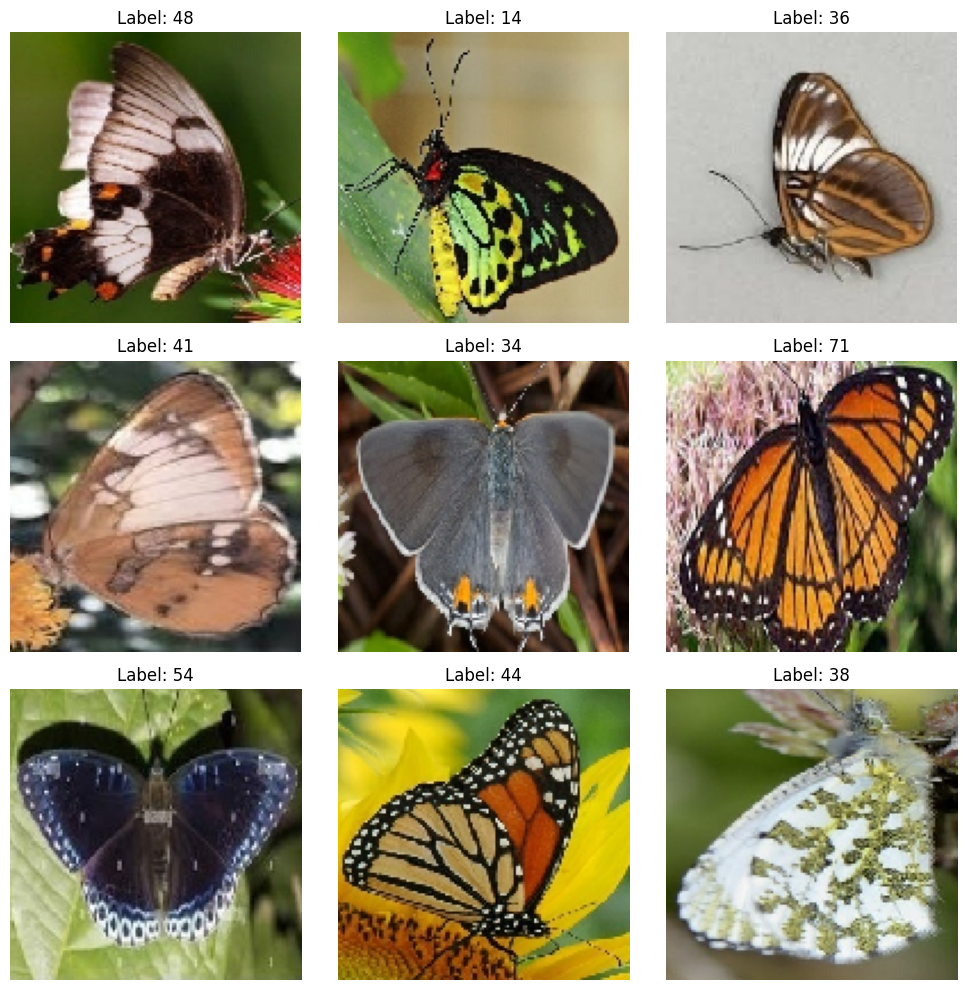

In [ ]:

# Get one batch of images and labels
images, labels = next(train_generator)

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].argmax()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Findings

During this analysis, I found that the dataset consists of 75 different butterfly species, and some species appear more frequently in this dataset than others. The top 10 classes (as shown above) make up a large amount of this dataset. As a result, this implies that there is a class imbalance in this dataset. Moreover, the images seem to have the same size and quality.

# Model Creation

In [ ]:
model = Sequential([
    # Convolutional layer with 32 filters, 3x3 kernel, ReLu activation
    # The rest of the layers/filters follow similar format
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(75, activation='softmax')
])

I utilized this pattern because each layer is able to progressively extract more complex features from the images, with filter increasing from 32 to 64 to 128. I utilized MaxPooling after each Convolutional layer, because it helps make training the data more computationally efficient, while also allowing the neural network to focus on the most important features from the inputs. The final flatten layer is used to convert the 3D feature map into a 1D feature vector. This in turn allows the connected layers to interpret the features. The Dense layer after Flatten() learns combinations from the vector of features. Dropout is used to help prevent overfitting, and the final Dense layer is utilized to classify the input image to the specific butterfly.

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# I utilized Adam optimizer as it is better than other optimizers for working efficiently with complex, high dimensional parameter spaces. This in
# turn allows for faster and more stable training.
# I utilized Categorical Crossentropy because it works well wtih the softmax outputs.

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.0164 - loss: 4.3091 - val_accuracy: 0.1036 - val_loss: 3.9143
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.0728 - loss: 3.8559 - val_accuracy: 0.2082 - val_loss: 3.2033
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.1739 - loss: 3.2694 - val_accuracy: 0.3251 - val_loss: 2.6733
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.2691 - loss: 2.8056 - val_accuracy: 0.4041 - val_loss: 2.2887
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.3617 - loss: 2.3751 - val_accuracy: 0.4503 - val_loss: 2.1245
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.4018 - loss: 2.1093 - val_accuracy: 0.4595 - val_loss: 1.9571
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.4554 - loss: 1.8455 - val_accuracy: 0.5169 - val_loss: 1.8023
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5312 - loss: 1.6026 - val_

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.5603 - loss: 1.7238
Test Loss: 1.7987
Test Accuracy: 0.5467


# Pre-Trained Model

In [ ]:
# Load pre-trained ResNet model without the classification layer
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

model2 = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(75, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile model
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train model
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 338ms/step - accuracy: 0.1345 - loss: 4.0065 - val_accuracy: 0.0144 - val_loss: 83.1370
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.4410 - loss: 2.1267 - val_accuracy: 0.0123 - val_loss: 6.4247
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.6261 - loss: 1.3060 - val_accuracy: 0.0144 - val_loss: 7.6170
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.7306 - loss: 0.9136 - val_accuracy: 0.0174 - val_loss: 5.2579
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.7875 - loss: 0.6992 - val_accuracy: 0.0390 - val_loss: 5.1817
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.8592 - loss: 0.4458 - val_accuracy: 0.3487 - val_loss: 2.9415
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.8654 - loss: 0.4388 - val_accuracy: 0.5774 - val_loss: 1.8621
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.8866 - loss:

In [ ]:
test_loss, test_accuracy = model2.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6511 - loss: 1.8309
Test Loss: 1.9150
Test Accuracy: 0.6369


Using ResNet50 + the top layer I added (because I needed an output layer with 75 classes), the model had a 63.69% test accuracy. My CNN model had a 54.67% test accuracy. Therefore, it seems that the ResNet model was about 9% more accurate than my CNN model. This is most likely due to the fact that the ResNet model I used is a pretrained model, that has already been trained on a lot of images. As a result, it is more generalizable, and was more effectively able to understand different types of butterfly images. My CNN however, is only trained on the butterfly dataset, and was not generalized with other image data. As a result, it seems to have performed worse than ResNet (as it might not be able to correctly classify images of butterflies it hasn't been trained a lot on).

In [ ]:
train_datagenerator_augmented = ImageDataGenerator(
    rescale=1./255,
    # Random rotation
    rotation_range=20,
    # Horizontal shift
    width_shift_range=0.1,
    # Vertical shift
    height_shift_range=0.1,
    # Shearing
    shear_range=0.1,
    # Zoom
    zoom_range=0.1,
    # Flip
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_aug = train_datagenerator_augmented.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 4549 validated image filenames belonging to 75 classes.


In [ ]:
model3 = Sequential([
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(75, activation='softmax')
])

In [ ]:
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history3 = model3.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=15
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.0183 - loss: 4.2927 - val_accuracy: 0.0810 - val_loss: 3.8594
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - accuracy: 0.0787 - loss: 3.8533 - val_accuracy: 0.2215 - val_loss: 3.0829
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.1691 - loss: 3.3048 - val_accuracy: 0.3323 - val_loss: 2.6239
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.2446 - loss: 2.8997 - val_accuracy: 0.3949 - val_loss: 2.2591
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - accuracy: 0.2882 - loss: 2.6112 - val_accuracy: 0.4318 - val_loss: 2.0657
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.3348 - loss: 2.3680 - val_accuracy: 0.4800 - val_loss: 1.9253
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.3723 - loss: 2.2448 - val_accuracy: 0.5087 - val_loss: 1.7997
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.3959 - loss: 2

In [ ]:
test_loss, test_accuracy = model3.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6356 - loss: 1.2575
Test Loss: 1.2988
Test Accuracy: 0.6256


I utilized the same CNN architecture as I did earlier, and for the same reason. I noticed that after using data augmentation, my CNN model performed around 6.5% better than when I did not use data augmentation. This is likely due to the fact that since data augmentation artificially creates diversity in my training data, my model is able to become more generalized, and as a result is better able to classify a given image.